In [63]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [64]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [65]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_GM12878", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_GM12878", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_GM12878": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_GM12878": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

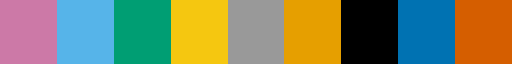

In [66]:
cmap

Network data loading

In [67]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [68]:
chip_atlas_gm12878 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_GM12878.tsv", sep="\t")

In [69]:
chip_atlas_gm12878.head()

,tf,Target_genes
0,ARID3A,SMARCD2
1,ARID3A,INTS5
2,ARID3A,LETM2
3,ARID3A,WDR74
4,ARID3A,KDM3A


In [70]:
gm12878 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_GM12878_with_ppi_with_dnase_with_atac_with_motifs_with_ccres.tsv", sep="\t")

gm12878 = gm12878.loc[gm12878.is_M2Kb & (gm12878.is_pls | gm12878.is_pels | gm12878.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
gm12878 = gm12878.loc[gm12878.tf.isin(collectri.source) & gm12878.tf.isin(chip_atlas_gm12878.tf)]
gm12878.shape

/scratch/46848996/ipykernel_7783/582809249.py:1: DtypeWarning: Columns (8,24,53,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.


(423210, 2)

In [71]:
chip_atlas_gm12878 = chip_atlas_gm12878.loc[chip_atlas_gm12878.tf.isin(gm12878.tf)]
chip_atlas_gm12878.shape

(1576755, 2)

In [72]:
collectri = collectri[collectri.source.isin(gm12878.tf)]

### Prepare cosmic

In [73]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 vs other leukemic cells

In [74]:
data = pd.read_csv("../data/case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Takao & Kentsis LRC,Metadata: Velten
Gene,,,,,,,,
AREG,7,0,"2,3179424781",1,44,7,NaN,Other
FOS,7,0,"2,0089384569",1,42,7,NaN,AP1 factors
FTH1,7,0,"1,2502755149",1,60,7,NaN,Erythromyeloid priming
SLC40A1,7,0,"1,2451559941",1,47,7,1.0,Erythromyeloid priming
CD69,6,0,"1,0858648734",1,39,6,NaN,Other
...,...,...,...,...,...,...,...,...
YPEL3,1,1,"0,0845519869",0,15,0,NaN,Other
YWHAZ,1,1,"0,0008226982",0,7,0,NaN,Erythromyeloid priming
ZEB2,2,2,"-0,1924227130",1,26,0,-1.0,Other


In [75]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [76]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
AREG,2.317942,-2.317942
FOS,2.008938,-2.008938
FTH1,1.250276,-1.250276
SLC40A1,1.245156,-1.245156
CD69,1.085865,-1.085865
...,...,...
ZSCAN18,0.277256,-0.277256
ZSCAN26,0.920350,-0.920350
ZSWIM6,0.433205,-0.433205


In [77]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,"Leukemia, Myelocytic, Acute",446/1703,4.340686e-30,3.762073e-26,0,0,2.015400,136.260247,RB1;CDA;CHIC2;SPI1;TFRC;BACH1;GLS;GJA1;HOXA9;M...
1,DisGeNET,leukemia,491/1941,2.413857e-29,1.046045e-25,0,0,1.931294,127.260209,RB1;CDA;CHIC2;SPI1;RNH1;TFRC;EHMT1;SMC4;GLS;SM...
2,DisGeNET,Acute lymphocytic leukemia,265/907,4.159066e-25,1.201554e-21,0,0,2.286223,128.347040,RB1;IL1RN;SPI1;GFI1;JMJD1C;IKZF1;ACTB;GLS;LGAL...
3,DisGeNET,Precursor Cell Lymphoblastic Leukemia Lymphoma,192/618,1.124858e-21,2.437286e-18,0,0,2.467956,119.045868,RB1;IL1RN;CSF1;IRS1;MPG;GFI1;ATN1;F13A1;SLA;JM...
4,DisGeNET,"Liver Cirrhosis, Experimental",227/801,8.673278e-20,1.503426e-16,0,0,2.171344,95.303432,IFITM1;WIPF1;GMFG;ICAM2;ZDHHC2;GLS;SMC2;LGALS3...
...,...,...,...,...,...,...,...,...,...,...
8662,DisGeNET,Ragged-red muscle fibers,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,TYMP
8663,DisGeNET,Rat Adrenal Gland Pheochromocytoma,1/42,9.993174e-01,9.996634e-01,0,0,0.128493,0.000088,BCL2L1
8664,DisGeNET,Retinal Dystrophies,14/178,9.995380e-01,9.997687e-01,0,0,0.448258,0.000207,PEX16;HGSNAT;PRPS1;GRN;SUCNR1;TRAF3IP1;PRPF8;T...
8665,DisGeNET,Syndactyly,4/85,9.996806e-01,9.997960e-01,0,0,0.259783,0.000083,GJA1;NOG;LMNA;ZSWIM6


In [78]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [79]:
de_genes = de_genes.T

In [80]:
dc.check_corr(gm12878, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
2872,TBP,ZNF217,-0.1102
2971,GABPA,ZNF217,-0.1057
2993,ETV6,NRF1,-0.1047
3211,CEBPZ,ZNF217,-0.0947
3498,NFYB,ZNF24,-0.0833
...,...,...,...
4,ELF1,PAX5,0.6129
3,FOS,NFYA,0.6178
2,PAX5,TCF12,0.6388
1,PAX5,SP1,0.6471


In [81]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
839,MYC,SREBF1,-0.0867
1095,MYC,SREBF2,-0.0696
1306,EBF1,SP1,-0.0563
1377,NRF1,STAT1,-0.0521
1424,MYC,RFX5,-0.0496
...,...,...,...
4,IRF3,IRF5,0.3704
3,IRF4,IRF5,0.3832
2,ARNT,NFATC3,0.3849
1,NFYA,NFYB,0.5330


In [82]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

gm12878

In [83]:
tf_acts_gm12878, tf_pvals_gm12878= dc.run_ulm(de_genes, gm12878, source='tf', target='gene_symbol', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [84]:
mask = tf_pvals_gm12878 < 0.05
active_tfs_gm12878 = tf_acts_gm12878.loc["leukemic", pd.DataFrame(tf_acts_gm12878 * mask).sum(axis=0) != 0].index.to_list()

In [85]:
tf_acts_gm12878.index = ["score"]
tf_pvals_gm12878.index = ["p_value"]
out_gm12878 = pd.merge(left=tf_acts_gm12878.T, right=tf_pvals_gm12878.T, left_index=True, right_index=True)
out_gm12878.to_csv("../data/3-tf_activity/aml_gm12878_activity_m2kb.tsv", sep="\t", index=False)

In [86]:
enr = gp.enrich(active_tfs_gm12878, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [87]:
enr = gp.enrich(active_tfs_gm12878, "DisGeNET")
enr.results["Network"] = "M2Kb_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [88]:
try:
    enr = gp.enrich(gene_list=active_tfs_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_GM12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_GM12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [89]:
heat = pd.concat([tf_acts_gm12878.rename({"leukemic": "score"}), tf_pvals_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_GM12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.164807,0.244184,M2Kb_GM12878
ARNT,0.991523,0.321506,M2Kb_GM12878
ATF2,-0.736021,0.461772,M2Kb_GM12878
ATF3,1.489844,0.136364,M2Kb_GM12878
ATF7,0.912641,0.361501,M2Kb_GM12878
...,...,...,...
ZEB1,0.168608,0.866115,M2Kb_GM12878
ZNF143,0.831334,0.405847,M2Kb_GM12878
ZNF217,1.009199,0.312956,M2Kb_GM12878
ZNF24,-0.163451,0.870174,M2Kb_GM12878


CollecTri

In [90]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight=None)
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [91]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

CREB1    -3.125075
HSF1     -2.961596
NFE2     -2.893968
NFIC     -2.653232
NFATC3   -2.573544
RB1      -2.522023
ELK1     -2.460927
JUNB     -2.162684
IRF5      2.349644
ELF1      2.671553
TCF7      2.791151
MYB       2.813285
RFX5      2.920896
EZH2      2.955058
SP1       3.195663
Name: leukemic, dtype: float32

In [92]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_gm12878_activity_collectri.tsv", sep="\t", index=False)

In [93]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [94]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [95]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [96]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.164807,0.244184,M2Kb_GM12878
ARNT,0.991523,0.321506,M2Kb_GM12878
ATF2,-0.736021,0.461772,M2Kb_GM12878
ATF3,1.489844,0.136364,M2Kb_GM12878
ATF7,0.912641,0.361501,M2Kb_GM12878
...,...,...,...
USF2,0.027700,0.977903,CollecTri
YBX1,1.925811,0.054217,CollecTri
YY1,1.131990,0.257724,CollecTri
ZBED1,-0.299977,0.764214,CollecTri


chip_atlas_gm12878

In [97]:
tf_acts_chip_atlas_gm12878, tf_pvals_chip_atlas_gm12878 = dc.run_ulm(de_genes, chip_atlas_gm12878.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [98]:
mask_chip_atlas_gm12878 = tf_pvals_chip_atlas_gm12878 < 0.05

active_tfs_chip_atlas_gm12878 = tf_acts_chip_atlas_gm12878.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_gm12878 * mask_chip_atlas_gm12878).sum(axis=0) != 0].index.to_list()

In [99]:
tf_acts_chip_atlas_gm12878.index = ["score"]
tf_pvals_chip_atlas_gm12878.index = ["p_value"]
out_chip_atlas_gm12878 = pd.merge(left=tf_acts_chip_atlas_gm12878.T, right=tf_pvals_chip_atlas_gm12878.T, left_index=True, right_index=True)
out_chip_atlas_gm12878.to_csv("../data/3-tf_activity/aml_gm12878_activity_ca_gm12878.tsv", sep="\t", index=False)

In [100]:
active_tfs_chip_atlas_gm12878

['ARID3A',
 'ETV6',
 'IKZF1',
 'IKZF2',
 'JUNB',
 'MED1',
 'MEF2B',
 'MTA2',
 'MYC',
 'NR2F1',
 'RELA',
 'SMAD1',
 'SMAD5',
 'TBP',
 'ZEB1',
 'ZNF384']

In [101]:
enr = gp.enrich(active_tfs_chip_atlas_gm12878, "OMIM_Expanded")
enr.results["Network"] = "CA_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [102]:
enr = gp.enrich(active_tfs_chip_atlas_gm12878, "DisGeNET")
enr.results["Network"] = "CA_GM12878"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [103]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_gm12878, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_GM12878"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_gm12878_hsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_GM12878"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [104]:
heat = pd.concat([tf_acts_chip_atlas_gm12878.rename({"leukemic": "score"}), tf_pvals_chip_atlas_gm12878.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_GM12878"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ARID3A,1.164807,0.244184,M2Kb_GM12878
ARNT,0.991523,0.321506,M2Kb_GM12878
ATF2,-0.736021,0.461772,M2Kb_GM12878
ATF3,1.489844,0.136364,M2Kb_GM12878
ATF7,0.912641,0.361501,M2Kb_GM12878
...,...,...,...
ZEB1,-2.221846,0.026364,CA_GM12878
ZNF143,0.686264,0.492597,CA_GM12878
ZNF217,0.997209,0.318739,CA_GM12878
ZNF24,-0.073682,0.941268,CA_GM12878


Plotting results

In [105]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM12878": 8,
            "CA_GM12878": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[6], pal[7], pal[8]]

In [106]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.000000e+01,10.000000,10.0,10.0,10.000000,10.000000,10.000000
mean,1.656358e-03,0.002878,0.0,0.0,45.458941,494.828229,3.228995
std,2.089202e-03,0.002969,0.0,0.0,22.089141,389.591668,1.037844
min,6.998989e-07,0.000059,0.0,0.0,23.403529,128.739250,2.244510
25%,1.105683e-05,0.000060,0.0,0.0,23.403529,128.739250,2.244510
50%,9.319863e-05,0.002880,0.0,0.0,44.918931,431.771932,3.216802
75%,4.083309e-03,0.005695,0.0,0.0,66.172421,863.692022,4.219575
max,4.083309e-03,0.005695,0.0,0.0,76.233716,1080.409378,4.229735


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_gm12878.svg


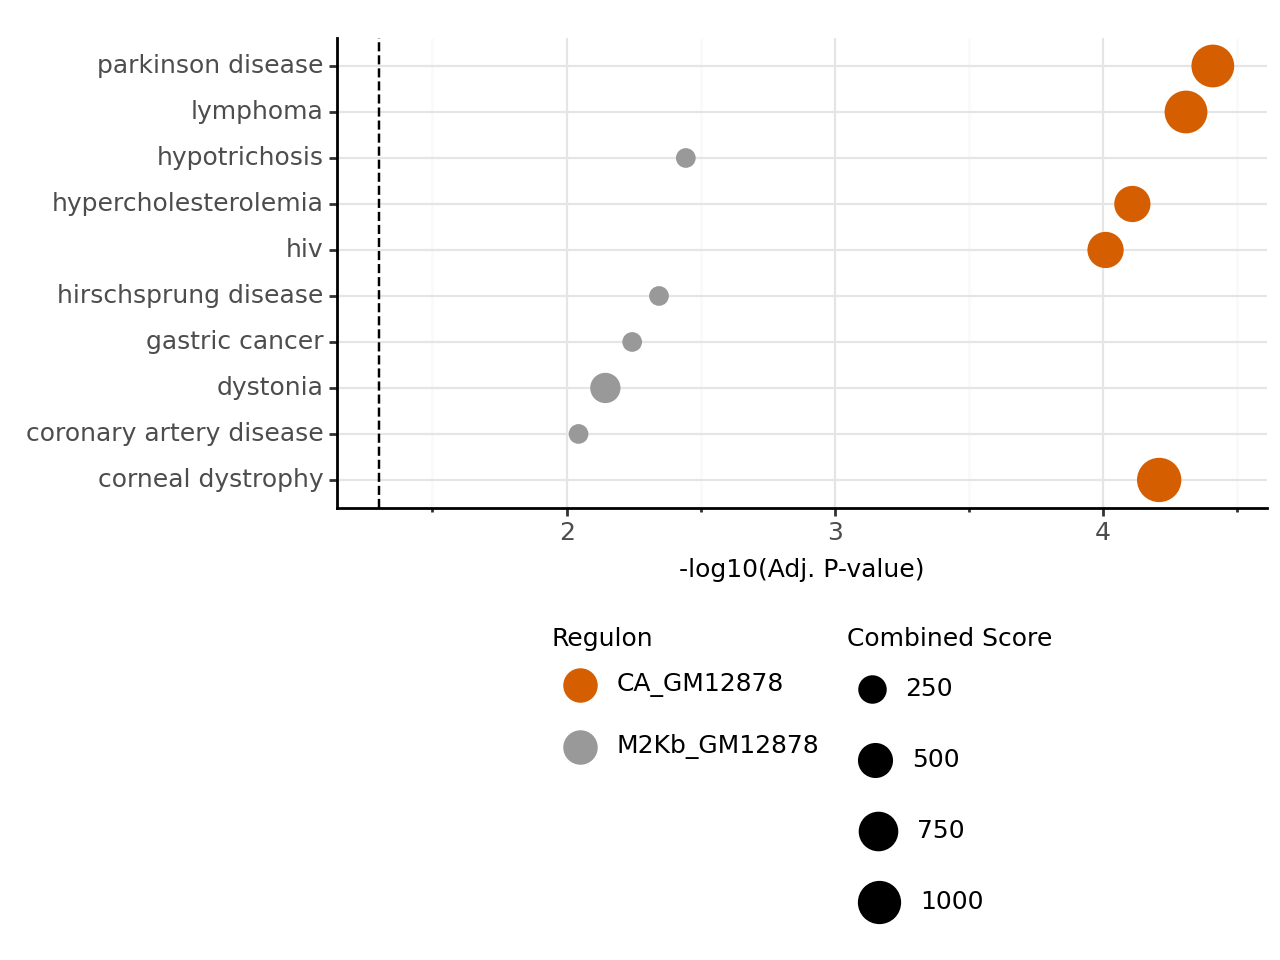

<Figure Size: (640 x 480)>

In [107]:
p = plot_enrich(aml_omim_enrich, [okabe[0], okabe[2]])
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [108]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,15.000000,15.0,15.0,15.000000,15.000000,15.000000
mean,1.516709e-07,0.000041,0.0,0.0,32.681843,526.903407,4.472550
std,1.583651e-07,0.000028,0.0,0.0,35.981242,576.402878,0.277157
min,2.990168e-08,0.000013,0.0,0.0,10.490821,163.272348,3.894887
25%,3.822571e-08,0.000025,0.0,0.0,14.827665,233.331533,4.307936
50%,7.809459e-08,0.000041,0.0,0.0,18.509135,289.737461,4.388877
75%,2.155249e-07,0.000049,0.0,0.0,26.632762,440.537733,4.599424
max,6.153786e-07,0.000127,0.0,0.0,135.612245,2219.341181,4.882315


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_gm12878.svg


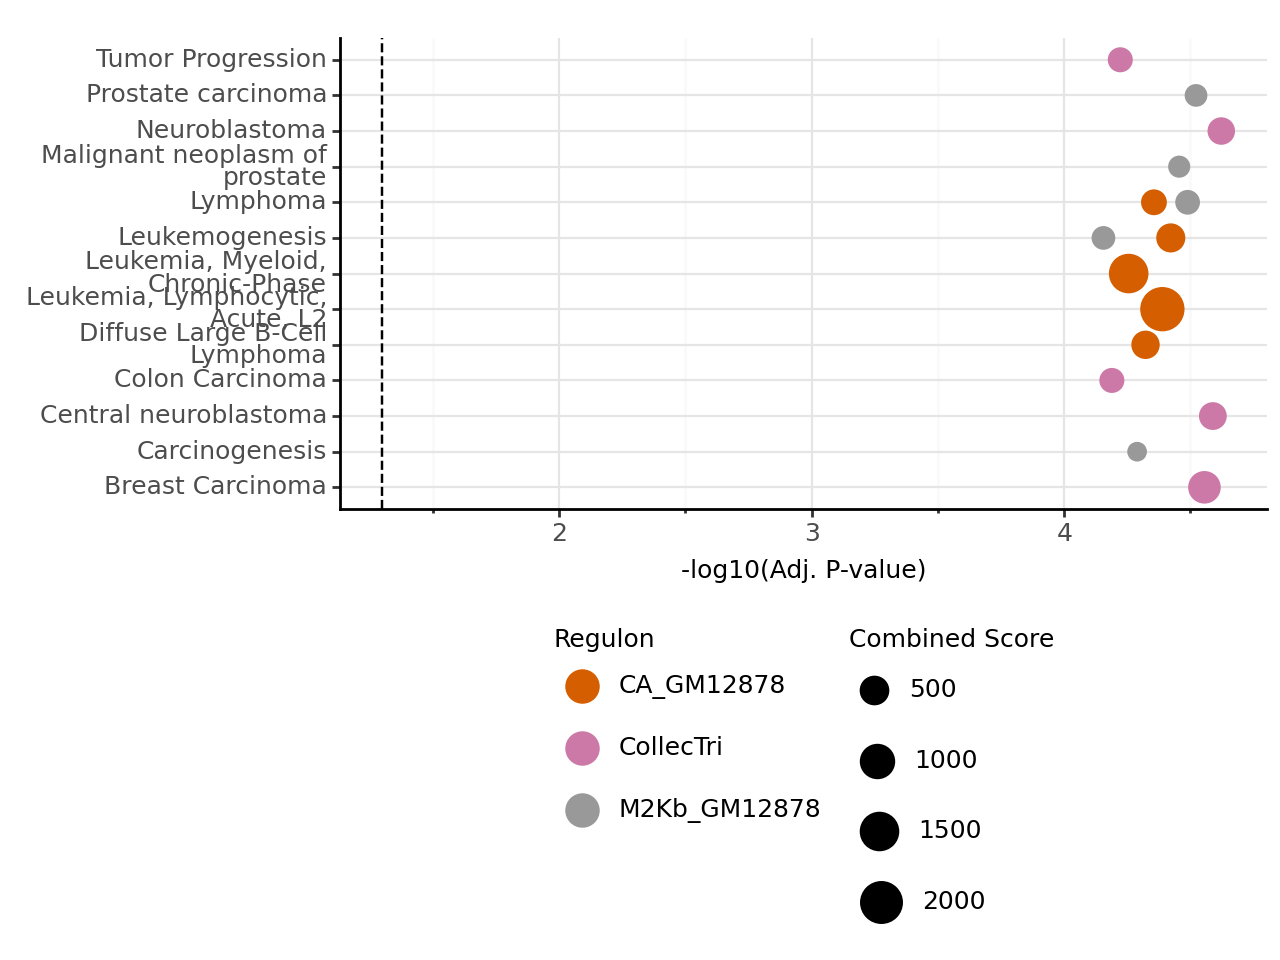

<Figure Size: (640 x 480)>

In [109]:
p = plot_enrich(aml_disreg_enrich, palette=okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [110]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.018727,0.037730,74.082919,301.614551,1.431124
std,0.006034,0.007505,24.629987,114.117584,0.084988
min,0.012628,0.030235,16.347709,68.556553,1.327732
25%,0.015773,0.030235,64.234694,244.968954,1.327732
50%,0.015773,0.035488,80.574150,327.375040,1.449913
75%,0.018897,0.047018,84.066667,348.832860,1.519483
max,0.031346,0.047018,108.085714,472.532137,1.519483


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_gm12878.svg


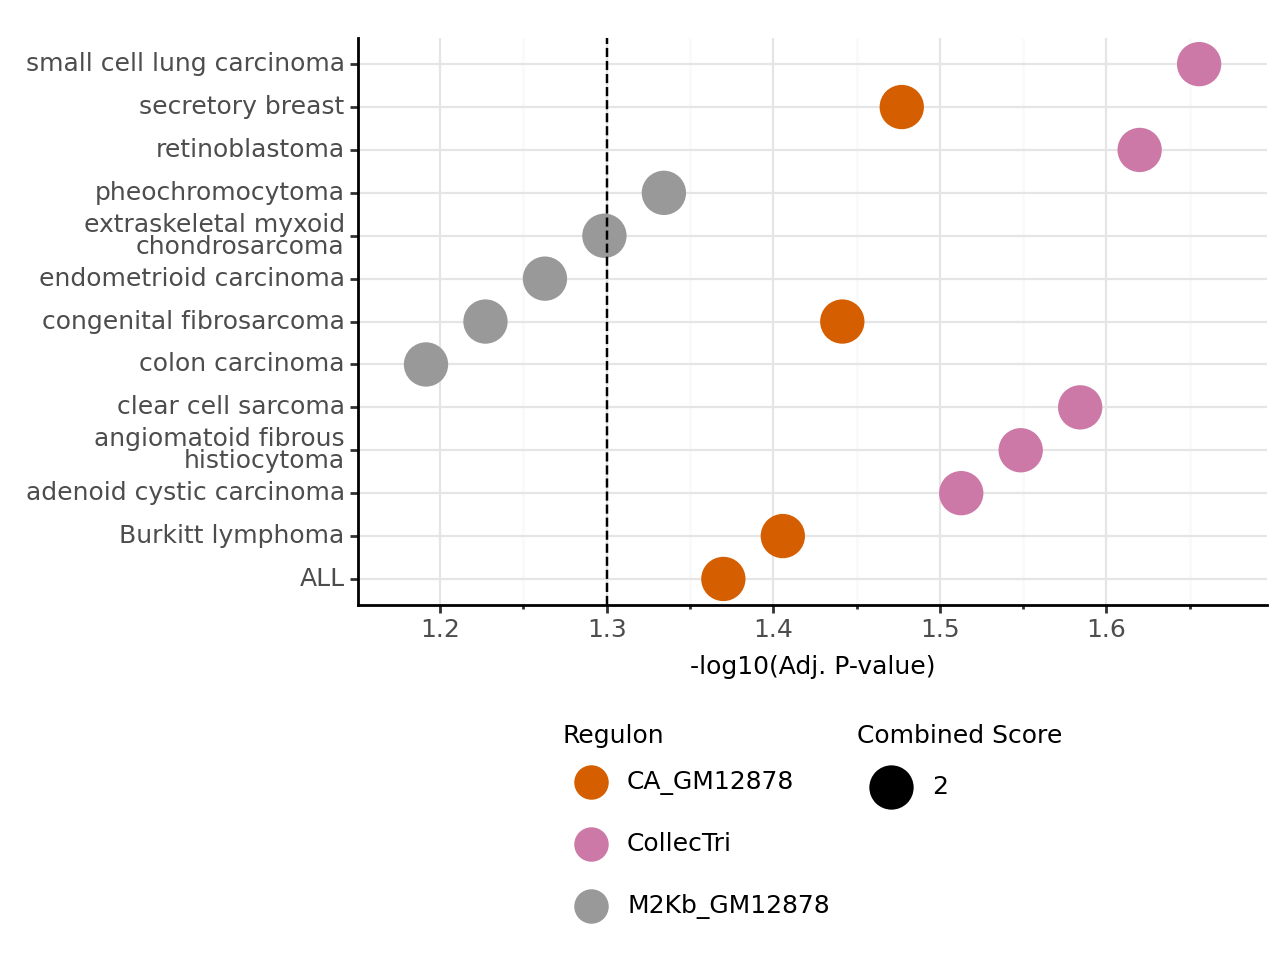

<Figure Size: (640 x 480)>

In [111]:
p = plot_enrich(aml_cosmic_enrich, okabe, size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_hsc_new_gm12878.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [112]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.018727,0.037730,74.082919,301.614551,1.431124
std,0.006034,0.007505,24.629987,114.117584,0.084988
min,0.012628,0.030235,16.347709,68.556553,1.327732
25%,0.015773,0.030235,64.234694,244.968954,1.327732
50%,0.015773,0.035488,80.574150,327.375040,1.449913
75%,0.018897,0.047018,84.066667,348.832860,1.519483
max,0.031346,0.047018,108.085714,472.532137,1.519483


In [113]:
megaheat.describe()

,score,p_value
count,306.000000,306.000000
mean,0.641551,0.357303
std,1.267801,0.297973
min,-3.125075,0.001409
25%,-0.149068,0.089746
50%,0.805952,0.304125
75%,1.509587,0.575971
max,3.195663,0.985231


In [114]:
megaheat.to_csv("../data/3-tf_activity/aml_gm12878_activity_estimates_hsc.tsv", sep="\t", index=False)

In [115]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [116]:
print(megaheat[megaheat.Network == "M2Kb_GM12878"].sort_values("score").to_string())

           score   p_value       Network      TF  log_p
SRF     1.990463  0.046625  M2Kb_GM12878     SRF    1.3
PKNOX1  2.016005  0.043883  M2Kb_GM12878  PKNOX1    1.4
TAF1    2.020756  0.043389  M2Kb_GM12878    TAF1    1.4
IKZF2   2.024344  0.043018  M2Kb_GM12878   IKZF2    1.4
CEBPB   2.068841  0.038642  M2Kb_GM12878   CEBPB    1.4
YBX1    2.118306  0.034226  M2Kb_GM12878    YBX1    1.5
NR2C1   2.188448  0.028709  M2Kb_GM12878   NR2C1    1.5
RELA    2.204725  0.027545  M2Kb_GM12878    RELA    1.6
MAX     2.250813  0.024465  M2Kb_GM12878     MAX    1.6
CHD4    2.291834  0.021980  M2Kb_GM12878    CHD4    1.7
STAT1   2.301539  0.021425  M2Kb_GM12878   STAT1    1.7
NFATC1  2.303510  0.021314  M2Kb_GM12878  NFATC1    1.7
ETV6    2.387940  0.017001  M2Kb_GM12878    ETV6    1.8
TCF12   2.477557  0.013280  M2Kb_GM12878   TCF12    1.9
SMAD5   2.514949  0.011954  M2Kb_GM12878   SMAD5    1.9
KLF5    2.563202  0.010417  M2Kb_GM12878    KLF5    2.0
BCL3    2.624146  0.008728  M2Kb_GM12878    BCL3

In [117]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

           score   p_value    Network      TF  log_p
CREB1  -3.125075  0.001794  CollecTri   CREB1    2.7
HSF1   -2.961596  0.003083  CollecTri    HSF1    2.5
NFE2   -2.893968  0.003830  CollecTri    NFE2    2.4
NFIC   -2.653232  0.008012  CollecTri    NFIC    2.1
NFATC3 -2.573544  0.010111  CollecTri  NFATC3    2.0
RB1    -2.522023  0.011717  CollecTri     RB1    1.9
ELK1   -2.460927  0.013911  CollecTri    ELK1    1.9
JUNB   -2.162684  0.030640  CollecTri    JUNB    1.5
IRF5    2.349644  0.018852  CollecTri    IRF5    1.7
ELF1    2.671553  0.007589  CollecTri    ELF1    2.1
TCF7    2.791151  0.005283  CollecTri    TCF7    2.3
MYB     2.813285  0.004934  CollecTri     MYB    2.3
RFX5    2.920896  0.003515  CollecTri    RFX5    2.5
EZH2    2.955058  0.003149  CollecTri    EZH2    2.5
SP1     3.195663  0.001409  CollecTri     SP1    2.9


In [118]:
megaheat

,score,p_value,Network,TF,log_p
CREB1,-3.125075,0.001794,CollecTri,CREB1,2.7
HSF1,-2.961596,0.003083,CollecTri,HSF1,2.5
NFE2,-2.893968,0.003830,CollecTri,NFE2,2.4
ARID3A,-2.797535,0.005180,CA_GM12878,ARID3A,2.3
NFIC,-2.653232,0.008012,CollecTri,NFIC,2.1
NFATC3,-2.573544,0.010111,CollecTri,NFATC3,2.0
RB1,-2.522023,0.011717,CollecTri,RB1,1.9
ELK1,-2.460927,0.013911,CollecTri,ELK1,1.9
ZEB1,-2.221846,0.026364,CA_GM12878,ZEB1,1.6
JUNB,-2.162684,0.030640,CollecTri,JUNB,1.5


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


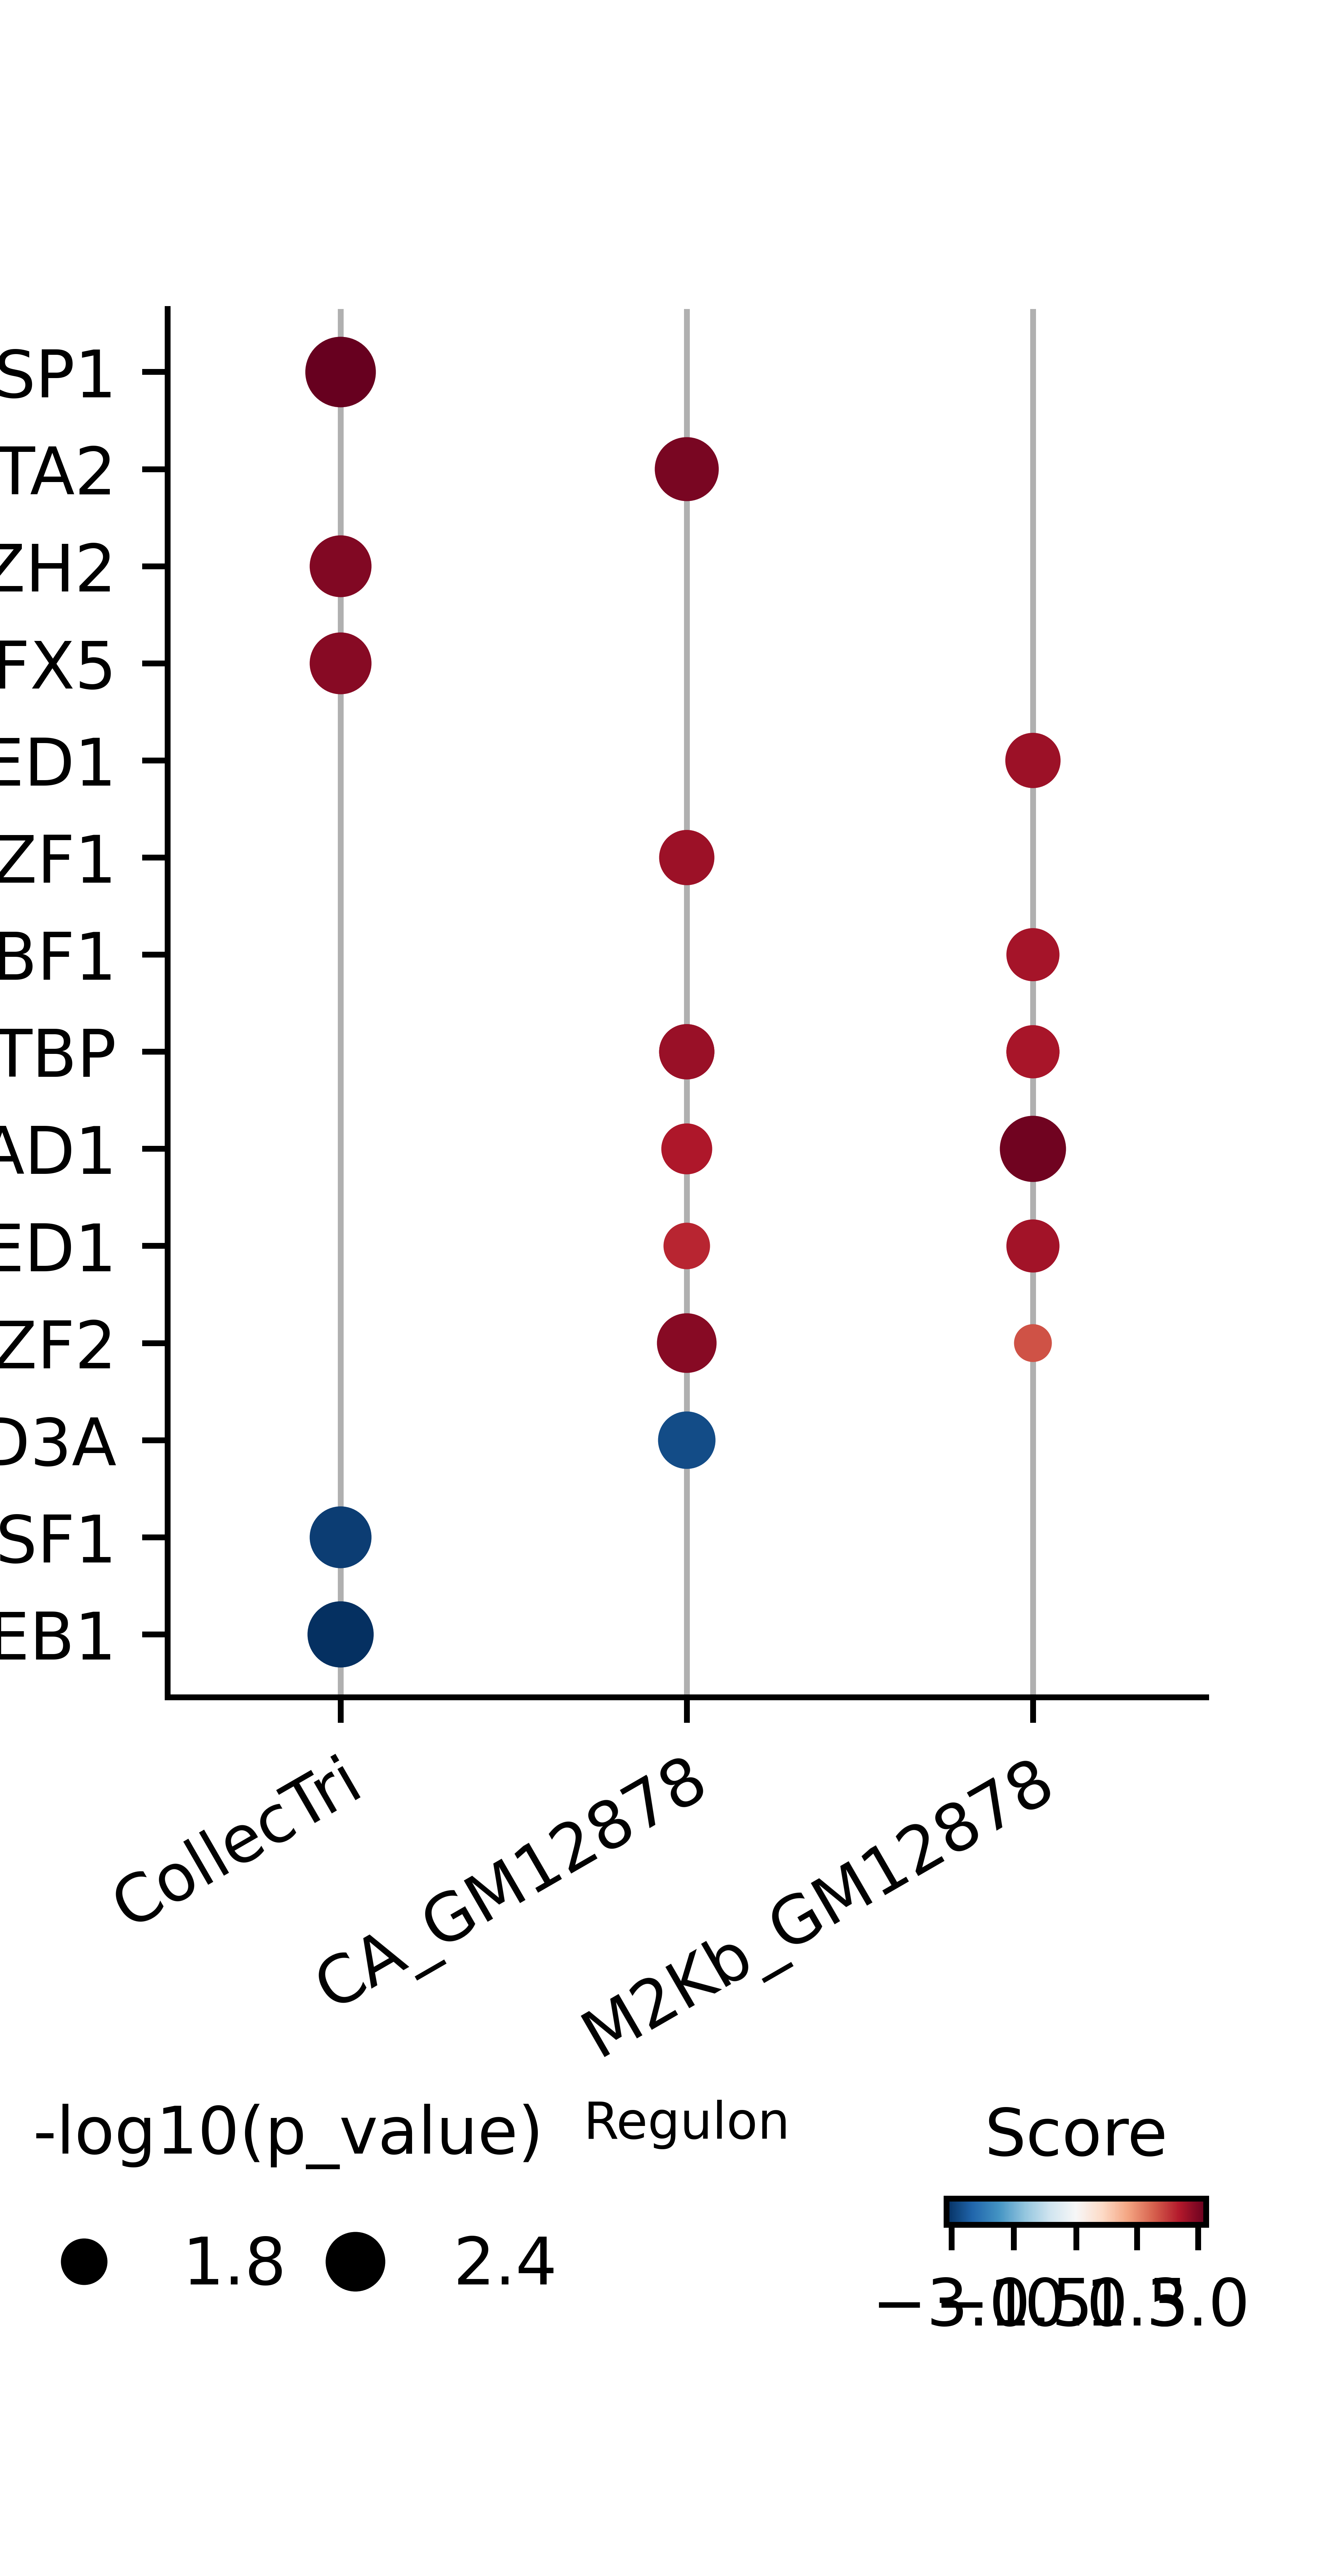

In [119]:
plt.close()
out = pd.DataFrame()
#interesting_tf = ["GATA1", "GATA2", "KLF1", "SPI1"]
interesting_tf = []
for net in ["CollecTri", "M2Kb_GM12878", "CA_GM12878"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out, scale=0.5)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_hsc_gm12878.svg", dpi=720, format="svg")
plt.show()

In [120]:
out.sort_values("TF")

,score,p_value,Network,TF,log_p
ARID3A,-2.797535,0.005180,CA_GM12878,ARID3A,2.3
CREB1,-3.125075,0.001794,CollecTri,CREB1,2.7
EBF1,2.657062,0.007922,M2Kb_GM12878,EBF1,2.1
EZH2,2.955058,0.003149,CollecTri,EZH2,2.5
HSF1,-2.961596,0.003083,CollecTri,HSF1,2.5
IKZF1,2.722288,0.006518,CA_GM12878,IKZF1,2.2
IKZF2,2.024344,0.043018,M2Kb_GM12878,IKZF2,1.4
IKZF2,2.899107,0.003768,CA_GM12878,IKZF2,2.4
MED1,2.676897,0.007469,M2Kb_GM12878,MED1,2.1
MED1,2.425308,0.015351,CA_GM12878,MED1,1.8


In [121]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

In [122]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

CREB1, HSF1, NFE2, NFIC, NFATC3, RB1, ELK1, JUNB, IRF5, ELF1, TCF7, MYB, RFX5, EZH2, SP1


In [123]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_hsc.tsv", sep="\t", index=False)

In [124]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_GM12878"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_gm12878_hsc.tsv", sep="\t", index=False)